In [ ]:
import serial
from firebase import firebase
import re
import time
import csv


fieldnames = ["sno", "hart", "temp"]
arduino = serial.Serial("COM5")
arduino.baudrate = 9600
sno = 0
temp = str(98)
base = firebase.FirebaseApplication('https://final-1e929.firebaseio.com/', None)
with open('data.csv', 'w') as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    csv_writer.writeheader()


while(True):
        sno += 1
        xdata = int(arduino.readline())
        data = {
        'sno' : sno,
        'hart' : xdata,
        'temp' : temp
        }
        with open('data.csv', 'a') as csv_file:
            csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            csv_writer.writerow(data)

        print(str(sno) + " " + str(xdata) + " " + temp)
        base.post('/final-1e929/sensordata', data)

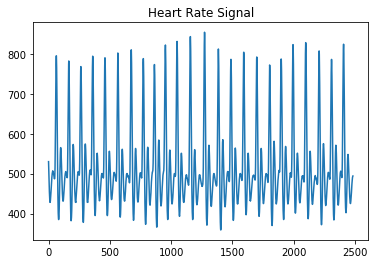

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import time
data1 = pd.read_csv('data1.csv')
plt.title("Heart Rate Signal") 
plt.plot(data1.hart) 
plt.show()

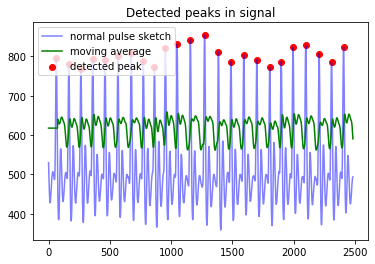

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

dataset = pd.read_csv("data1.csv")

#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 100 #The example dataset was recorded at 100Hz

mov_avg = dataset['hart'].rolling(int(hrw*fs)).mean()      #Calculate moving average

avg_hr = (np.mean(dataset.hart))
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]     # removing NaN values
mov_avg = [x*1.2 for x in mov_avg] 
dataset['hart_rollingmean'] = mov_avg 

#Mark regions of interest
window = []
peaklist = []
listpos = 0 
for datapoint in dataset.hart:
    rollingmean = dataset.hart_rollingmean[listpos]     # Get local mean
    if (datapoint < rollingmean) and (len(window) < 1):  # do nothing
        listpos += 1
    elif (datapoint > rollingmean): # mark ROI
        window.append(datapoint)
        listpos += 1
    else:                              #If signal drops below local mean determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition)               #Add detected peak to list
        window = [] 
        listpos += 1

ybeat = [dataset.hart[x] for x in peaklist]            #Get the y-value of all peaks for plotting purposes

plt.title("Detected peaks in signal")
#plt.xlim(0,2500)
plt.plot(dataset.hart, alpha=0.5, color='blue', label = 'normal pulse sketch') 
plt.plot(mov_avg, color ='green', label = 'moving average') 
plt.scatter(peaklist, ybeat, color='red',label = 'detected peak') 
plt.legend()
plt.show()


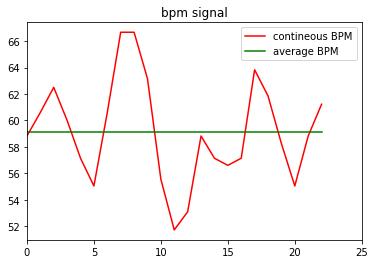

In [6]:
RR_list = []
cnt = 0

while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) 
    ms_dist = ((RR_interval / fs) * 1000.0) 
    RR_list.append(ms_dist) 
    cnt += 1


bpml =[]
for i in range(len(RR_list)):
    bpm = 60000 / RR_list[i]
    bpml.append(bpm)


plt.title("bpm signal")
plt.xlim(0,25)
plt.plot(bpml,color = 'red',label = 'contineous BPM')

k = np.mean(bpml)
l = [k]*23
plt.plot(l,color = 'green',label = 'average BPM')
plt.legend()
plt.show()